In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xg

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
print(df.head())
print(len(df))
print(df.dtypes)

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
10886
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual         

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.96047

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


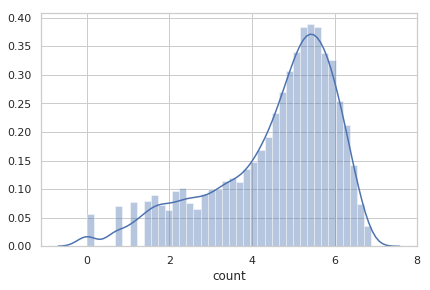

In [5]:
print(df.describe())
# sn.distplot(df['count'])

# Distribution non normalement centrée, à recentrer par un log

sns.distplot(df['count'].apply(lambda count:np.log(count)))

In [6]:
# Distribution des colonnes

# Catégoriques :
print(df.season.value_counts())
print(df.weather.value_counts())
print(df.holiday.value_counts())
print(df.workingday.value_counts())

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64


In [7]:
df.iloc[0]

datetime      2011-01-01 00:00:00
season                          1
holiday                         0
workingday                      0
weather                         1
temp                         9.84
atemp                      14.395
humidity                       81
windspeed                       0
casual                          3
registered                     13
count                          16
Name: 0, dtype: object

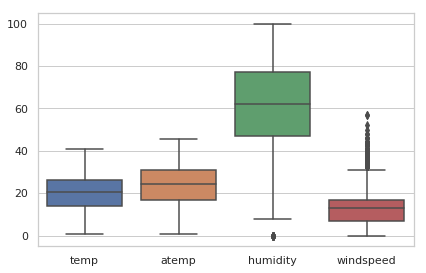

In [8]:
# Linéaires 
sns.boxplot(data=df[['temp','atemp', 'humidity', 'windspeed']])

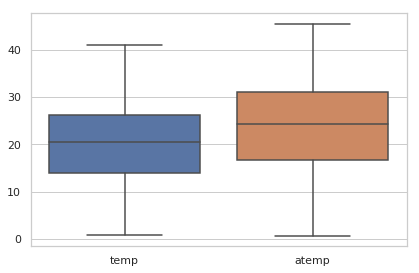

In [9]:
sns.boxplot(data=df[['temp','atemp']])

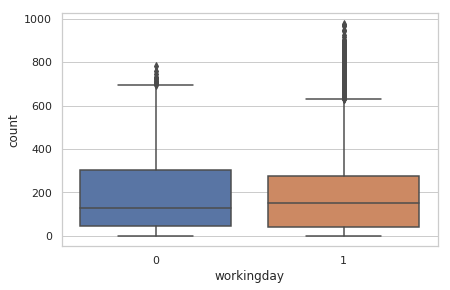

In [10]:
# Distribution en fonction du nombre de locations :


#sns.boxplot(data=df, x='season', y='count')
#sns.boxplot(data=df, x='humidity', y='count')
sns.boxplot(data=df, x='workingday', y='count')
#sns.boxplot(data=df, x='windspeed', y='count')
#sns.boxplot(data=df, x='weather', y='count')
#sns.boxplot(data=df, x='temp', y='count')
#sns.boxplot(data=df, x='atemp', y='count')

#### Premières observations

- Moins de locations à la saison 1 
- Le mauvais temps semble influer sur les locations de vélo
- Plus l'humidité est faible, plus il y a de locations, jusqu'à un certain seuil
- Working / Holiday semble peu influent
- Temp et atemp semblent assez corrélées
- Date inutilisable au format actuel
- Pas de valeurs manquantes 
- Count = registered + casual, ces 2 colonnes ne sont pas exploitables  
    (données décomposées du résultat (count) + pas d'importance pour prédire le nombre de locations, plutôt "qui")

In [11]:
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [12]:
train_df = df.copy()

## Nettoyage des données ##
## Formattage des variables temporelles et catégoriques ##

train_df['datetime'] = df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
train_df['hour'] = train_df['datetime'].apply(lambda date:date.hour)
train_df['weekday'] = train_df['datetime'].apply(lambda date:date.weekday())
train_df['month'] = train_df['datetime'].apply(lambda date:date.month)
train_df['year'] = train_df['datetime'].apply(lambda date:date.year)



## La disitribution de count n'étant pas centrée, on passe par un logarithme pour la recentrer normalement
train_df['count'] = train_df['count'].apply(lambda count:np.log(count))

train_df = train_df.drop(['datetime','atemp', 'casual', 'registered', 'weekday','windspeed'], axis=1)
train_df.head()

,season,holiday,workingday,weather,temp,humidity,count,hour,month,year
0,1,0,0,1,9.84,81,2.772589,0,1,2011
1,1,0,0,1,9.02,80,3.688879,1,1,2011
2,1,0,0,1,9.02,80,3.465736,2,1,2011
3,1,0,0,1,9.84,75,2.564949,3,1,2011
4,1,0,0,1,9.84,75,0.000000,4,1,2011


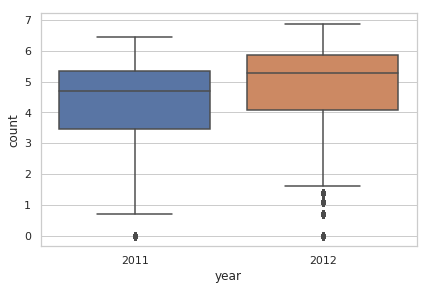

In [13]:
# Analyse temporelle

## Répartition des données 
## Horaire 
#sns.boxplot(x='hour',data=train_df,y='count')
## Journalière 
#sns.boxplot(x='weekday',data=train_df,y='count')
## Mensuelle 
#sns.boxplot(x='month',data=train_df,y='count')
## Annuelle 
sns.boxplot(x='year',data=train_df,y='count')


In [14]:
# Training
# Modèle 1 : random forest

test_df=pd.read_csv('data/test.csv')

y_datetime_test = test_df['datetime'].copy()
test_df['datetime'] = test_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
test_df['hour'] = test_df['datetime'].apply(lambda date:date.hour)
test_df['weekday'] = test_df['datetime'].apply(lambda date:date.weekday())
test_df['month'] = test_df['datetime'].apply(lambda date:date.month)
test_df['year'] = test_df['datetime'].apply(lambda date:date.year)

print(test_df.dtypes)


datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
hour                   int64
weekday                int64
month                  int64
year                   int64
dtype: object


In [15]:

train_cols = ['season','holiday','workingday','weather','temp','humidity','hour','month','year']
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(train_df[train_cols],train_df['count'])


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
y_test = regr.predict(test_df[train_cols])

In [17]:
sub = y_datetime_test.to_frame().assign(count=pd.Series(y_test).values)


# Repasser le count en format d'entrée :
sub['count'].apply(lambda x:np.exp(x))


sub.to_csv("results_regr.csv", index=False)

In [18]:
# Modèle xgboost

# Pour utiliser xgboost sur des séries temporelles, il semble plus performant
# de décomposer les colonnes catégoriques pour obtenir une matrice de valeurs 0/1

xtrain_df = train_df.copy()
#xtrain_df = xtrain_df.drop(['windspeed'])


## Application d'un tutoriel ##
#'adding dummy varibles to categorical variables'
weather_df=pd.get_dummies(xtrain_df['weather'],prefix='w',drop_first=True)
year_df=pd.get_dummies(xtrain_df['year'],prefix='y',drop_first=True)
month_df=pd.get_dummies(xtrain_df['month'],prefix='m',drop_first=True)
hour_df=pd.get_dummies(xtrain_df['hour'],prefix='h',drop_first=True)
season_df=pd.get_dummies(xtrain_df['season'],prefix='s',drop_first=True)

xtrain_df=xtrain_df.join(weather_df)
xtrain_df=xtrain_df.join(year_df)
xtrain_df=xtrain_df.join(month_df)                     
xtrain_df=xtrain_df.join(hour_df)
xtrain_df=xtrain_df.join(season_df)
                     
xtrain_df.head()

,season,holiday,workingday,weather,temp,humidity,count,hour,month,year,...,h_17,h_18,h_19,h_20,h_21,h_22,h_23,s_2,s_3,s_4
0,1,0,0,1,9.84,81,2.772589,0,1,2011,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,9.02,80,3.688879,1,1,2011,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,9.02,80,3.465736,2,1,2011,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,9.84,75,2.564949,3,1,2011,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,9.84,75,0.000000,4,1,2011,...,0,0,0,0,0,0,0,0,0,0


In [19]:
xtrain_df.columns

Index([u'season', u'holiday', u'workingday', u'weather', u'temp', u'humidity',
       u'count', u'hour', u'month', u'year', u'w_2', u'w_3', u'w_4', u'y_2012',
       u'm_2', u'm_3', u'm_4', u'm_5', u'm_6', u'm_7', u'm_8', u'm_9', u'm_10',
       u'm_11', u'm_12', u'h_1', u'h_2', u'h_3', u'h_4', u'h_5', u'h_6',
       u'h_7', u'h_8', u'h_9', u'h_10', u'h_11', u'h_12', u'h_13', u'h_14',
       u'h_15', u'h_16', u'h_17', u'h_18', u'h_19', u'h_20', u'h_21', u'h_22',
       u'h_23', u's_2', u's_3', u's_4'],
      dtype='object')

In [20]:
train_cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
               'hour', 'month', 'year', 'w_2', 'w_3', 'w_4', 'y_2012',
               'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10',
               'm_11', 'm_12', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
               'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14',
               'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22',
               'h_23', 's_2', 's_3', 's_4']
xgr=xg.XGBRegressor(max_depth=8,min_child_weight=8,gamma=0.4)
xgr.fit(xtrain_df[train_cols],train_df['count'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=8, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
# Calcul d'un gridsearch pour optimiser les paramètres en entrée du régresseur
# Calcul des paramètres par duo sauf le gamma 

parameters=[{'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}]
#{'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}]
#{'gamma':[i/10.0 for i in range(0,5)]}]
#{'max_depth':[8,9,10,11,12],'min_child_weight':[4,5,6,7,8]}]

grid_search= GridSearchCV(estimator=xgr, param_grid=parameters, cv=10,n_jobs=-1)


print (1)
grid_search=grid_search.fit(xtrain_df[train_cols],xtrain_df['count'])
print (2)
best_accuracy=grid_search.best_score_
best_parameters=grid_search.best_params_
print (best_accuracy)
print (best_parameters)

1
2
0.9247313850171733
{'subsample': 0.8, 'colsample_bytree': 0.6}


In [24]:
xgr=xg.XGBRegressor(max_depth=8,min_child_weight=8,gamma=0.4,colsample_bytree=0.8,subsample=0.6)
xgr.fit(xtrain_df[train_cols],xtrain_df['count'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [25]:
test_df=pd.read_csv('data/test.csv')



# Feature engineering des données de test
xtest_df = test_df.copy()

y_datetime_test = xtest_df['datetime'].copy()

xtest_df['datetime']=xtest_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
xtest_df['hour']=xtest_df['datetime'].apply(lambda x:x.hour)
xtest_df['month']=xtest_df['datetime'].apply(lambda x:x.month)
xtest_df['year']=xtest_df['datetime'].apply(lambda x:x.year)
xtest_df = xtest_df.drop(['datetime','atemp','windspeed'], axis=1)


weather_df=pd.get_dummies(xtest_df['weather'],prefix='w',drop_first=True)
year_df=pd.get_dummies(xtest_df['year'],prefix='y',drop_first=True)
month_df=pd.get_dummies(xtest_df['month'],prefix='m',drop_first=True)
hour_df=pd.get_dummies(xtest_df['hour'],prefix='h',drop_first=True)
season_df=pd.get_dummies(xtest_df['season'],prefix='s',drop_first=True)


xtest_df=xtest_df.join(weather_df)
xtest_df=xtest_df.join(year_df)
xtest_df=xtest_df.join(month_df)                     
xtest_df=xtest_df.join(hour_df)
xtest_df=xtest_df.join(season_df)


test_cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
               'hour', 'month', 'year', 'w_2', 'w_3', 'w_4', 'y_2012',
               'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10',
               'm_11', 'm_12', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
               'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14',
               'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22',
               'h_23', 's_2', 's_3', 's_4']

In [26]:
y_test = xgr.predict(xtest_df[test_cols])

In [27]:
y_test

array([2.4131563, 1.2123432, 0.910956 , ..., 4.9422784, 4.7234898,
       4.183781 ], dtype=float32)

In [28]:
sub = y_datetime_test.to_frame().assign(count=pd.Series(y_test).values)


# Repasser le count en format d'entrée :
sub['count'].apply(lambda x:np.exp(x))
sub.to_csv("results_xgb.csv", index=False)